In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import lightgbm as lgb
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')


Load Datasets Using Pandas



In [3]:
import pandas as pd

# Load datasets
train_data = pd.read_csv('train.csv')
stores_data = pd.read_csv('stores.csv')
oil_data = pd.read_csv('oil.csv')
holidays_data = pd.read_csv('holidays_events.csv')


 Interpolate Missing Oil Prices

In [4]:
# Convert oil date column
oil_data['date'] = pd.to_datetime(oil_data['date'])

# Interpolate and forward-fill oil price
oil_data['dcoilwtico'] = oil_data['dcoilwtico'].interpolate(method='linear')
oil_data['dcoilwtico'] = oil_data['dcoilwtico'].fillna(method='ffill')


Convert Date Columns to Datetime

In [5]:
train_data['date'] = pd.to_datetime(train_data['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])


Merge All Data into One Main DataFrame


In [6]:
# Merge store info into training data
merged_data = pd.merge(train_data, stores_data, on='store_nbr', how='left')

# Merge oil prices
merged_data = pd.merge(merged_data, oil_data, on='date', how='left')

# Filter holidays to only include national holidays that are not transferred
national_holidays = holidays_data[
    (holidays_data['locale'] == 'National') &
    (holidays_data['transferred'] == False)
][['date', 'description']]
national_holidays['is_holiday'] = 1

# Merge holiday info
merged_data = pd.merge(merged_data, national_holidays, on='date', how='left')
merged_data['is_holiday'] = merged_data['is_holiday'].fillna(0)


Finalize

In [7]:
# Sort by date
merged_data = merged_data.sort_values('date').reset_index(drop=True)

# Preview
merged_data.head()


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,description,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,Primer dia del ano,1.0
1,1194,2013-01-01,42,CELEBRATION,0.0,0,Cuenca,Azuay,D,2,NaN,Primer dia del ano,1.0
2,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2,NaN,Primer dia del ano,1.0
3,1192,2013-01-01,42,BOOKS,0.0,0,Cuenca,Azuay,D,2,NaN,Primer dia del ano,1.0
4,1191,2013-01-01,42,BEVERAGES,0.0,0,Cuenca,Azuay,D,2,NaN,Primer dia del ano,1.0


Time-Based Features

In [13]:
# Extract time-based features
merged_data['day'] = merged_data['date'].dt.day
merged_data['week'] = merged_data['date'].dt.isocalendar().week.astype(int)
merged_data['month'] = merged_data['date'].dt.month
merged_data['year'] = merged_data['date'].dt.year
merged_data['day_of_week'] = merged_data['date'].dt.dayofweek  # Monday=0, Sunday=6

Identify Seasonal Trends

In [15]:
# Group by month and calculate average sales
monthly_avg_sales = merged_data.groupby('month')['sales'].mean().reset_index()
monthly_avg_sales.columns = ['month', 'avg_sales']


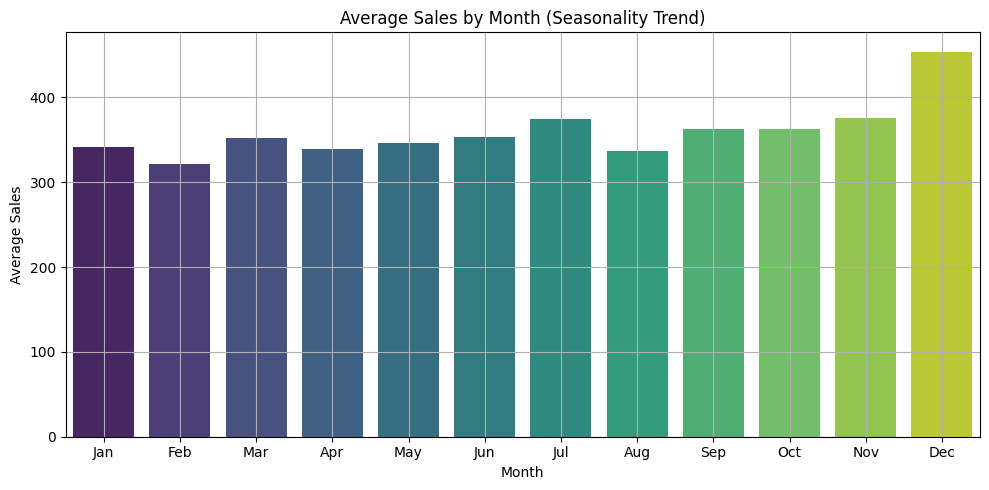

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_avg_sales, x='month', y='avg_sales', palette='viridis')

plt.title('Average Sales by Month (Seasonality Trend)')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()


Event-Based Features

In [9]:
# Already created is_holiday during merging

# Promotion flag
if 'onpromotion' in merged_data.columns:
    merged_data['is_promotion'] = merged_data['onpromotion'].fillna(0).astype(int)

# Government payday: 15th and last day of the month
merged_data['is_payday'] = merged_data['date'].dt.day.isin(
    [15] + merged_data['date'].dt.days_in_month.tolist()
).astype(int)

# Earthquake day: April 16, 2016
merged_data['earthquake_impact'] = (merged_data['date'] == pd.Timestamp('2016-04-16')).astype(int)


Rolling Statistics

In [10]:
# Sort by store-family-date for time series rolling
merged_data = merged_data.sort_values(by=['store_nbr', 'family', 'date'])

# Rolling mean & std (7-day window)
merged_data['rolling_mean_7'] = merged_data.groupby(['store_nbr', 'family'])['sales']\
    .transform(lambda x: x.shift(1).rolling(window=7).mean())

merged_data['rolling_std_7'] = merged_data.groupby(['store_nbr', 'family'])['sales']\
    .transform(lambda x: x.shift(1).rolling(window=7).std())

# Lag features (previous week and month)
merged_data['lag_7'] = merged_data.groupby(['store_nbr', 'family'])['sales']\
    .transform(lambda x: x.shift(7))

merged_data['lag_30'] = merged_data.groupby(['store_nbr', 'family'])['sales']\
    .transform(lambda x: x.shift(30))


Store-Specific Aggregations

In [11]:
# Average sales by store type (from previous stores_data merge)
avg_sales_by_type = merged_data.groupby('type')['sales'].mean().to_dict()
merged_data['avg_sales_store_type'] = merged_data['type'].map(avg_sales_by_type)

# Top-selling product families per cluster
total_sales_by_cluster_family = merged_data.groupby(['cluster', 'family'])['sales'].sum().reset_index()
top_families = total_sales_by_cluster_family.sort_values(['cluster', 'sales'], ascending=[True, False])
top_family_per_cluster = top_families.groupby('cluster').first().reset_index()[['cluster', 'family']]
top_family_dict = dict(zip(top_family_per_cluster['cluster'], top_family_per_cluster['family']))

# Flag rows where product is the top-selling family in that cluster
merged_data['is_top_family'] = merged_data.apply(
    lambda row: 1 if row['family'] == top_family_dict.get(row['cluster']) else 0, axis=1
)


Final Step: Check Engineered Features

In [ ]:
# View some new features
merged_data[['date', 'sales', 'rolling_mean_7', 'lag_7', 'is_holiday', 'is_payday', 'earthquake_impact']].head()


Visualize Sales Trends Over Time



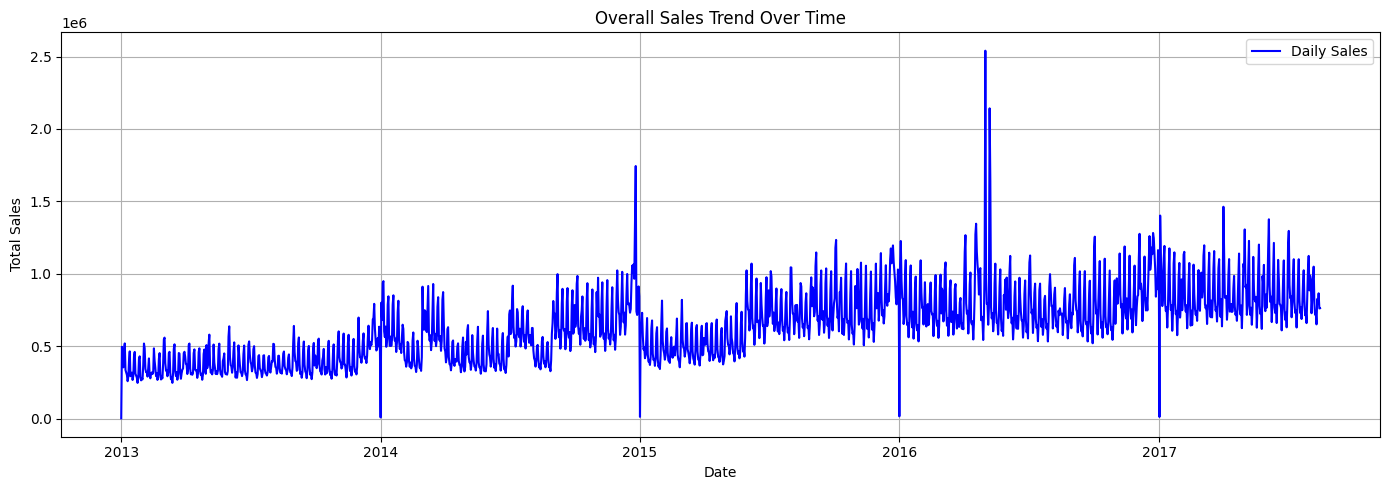

In [17]:
import matplotlib.pyplot as plt

# Aggregate daily sales
daily_sales = merged_data.groupby('date')['sales'].sum().reset_index()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Daily Sales', color='blue')
plt.title('Overall Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Analyze Sales Before and After Holidays & Promotions

a. Sales vs Holidays

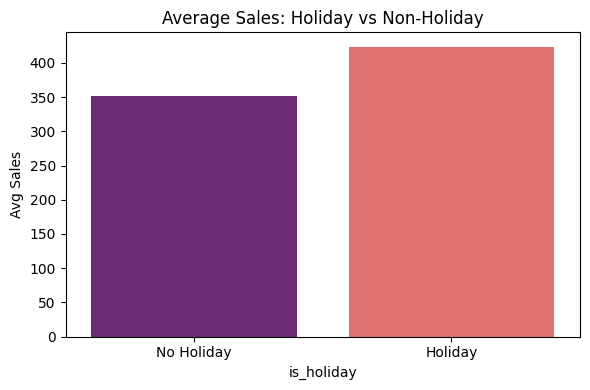

In [18]:
import seaborn as sns

# Average sales by holiday flag
holiday_sales = merged_data.groupby('is_holiday')['sales'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=holiday_sales, x='is_holiday', y='sales', palette='magma')
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.xticks([0, 1], ['No Holiday', 'Holiday'])
plt.ylabel('Avg Sales')
plt.tight_layout()
plt.show()


b. Sales vs Promotion

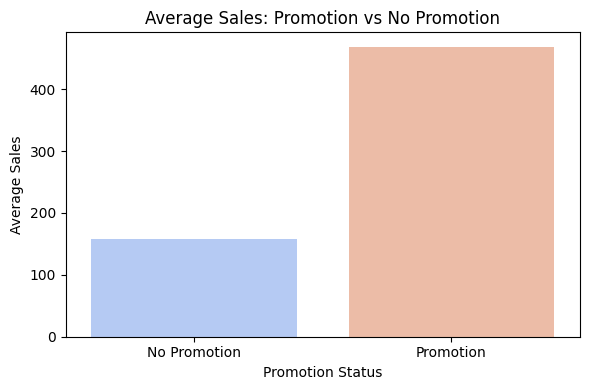

In [21]:
# Ensure 'is_promotion' exists and is binary (0/1)
if 'is_promotion' in merged_data.columns:
    merged_data['is_promotion'] = merged_data['is_promotion'].astype(int)

    # Aggregate mean sales by promotion status
    promo_sales = merged_data.groupby('is_promotion')['sales'].mean().reset_index()
    promo_sales['is_promotion'] = promo_sales['is_promotion'].map({0: 'No Promotion', 1: 'Promotion'})

    # Plot with seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 4))
    sns.barplot(data=promo_sales, x='is_promotion', y='sales', palette='coolwarm')
    plt.title('Average Sales: Promotion vs No Promotion')
    plt.xlabel('Promotion Status')
    plt.ylabel('Average Sales')
    plt.tight_layout()
    plt.show()


 Correlation Between Oil Prices and Sales



In [26]:
# Compute correlation matrix for oil price and sales
oil_corr_data = merged_data[['dcoilwtico', 'sales']].dropna()
correlation_matrix = oil_corr_data.corr()

# Print correlation number
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
            dcoilwtico     sales
dcoilwtico    1.000000 -0.078638
sales        -0.078638  1.000000


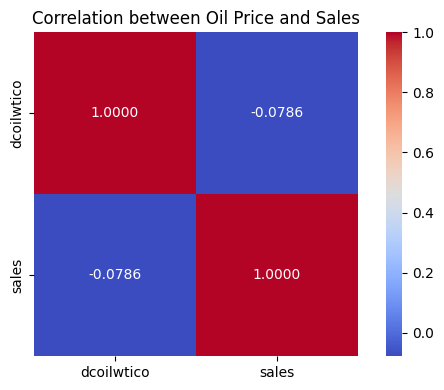

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", square=True)
plt.title('Correlation between Oil Price and Sales')
plt.tight_layout()
plt.show()


Identify Anomalies in the Data

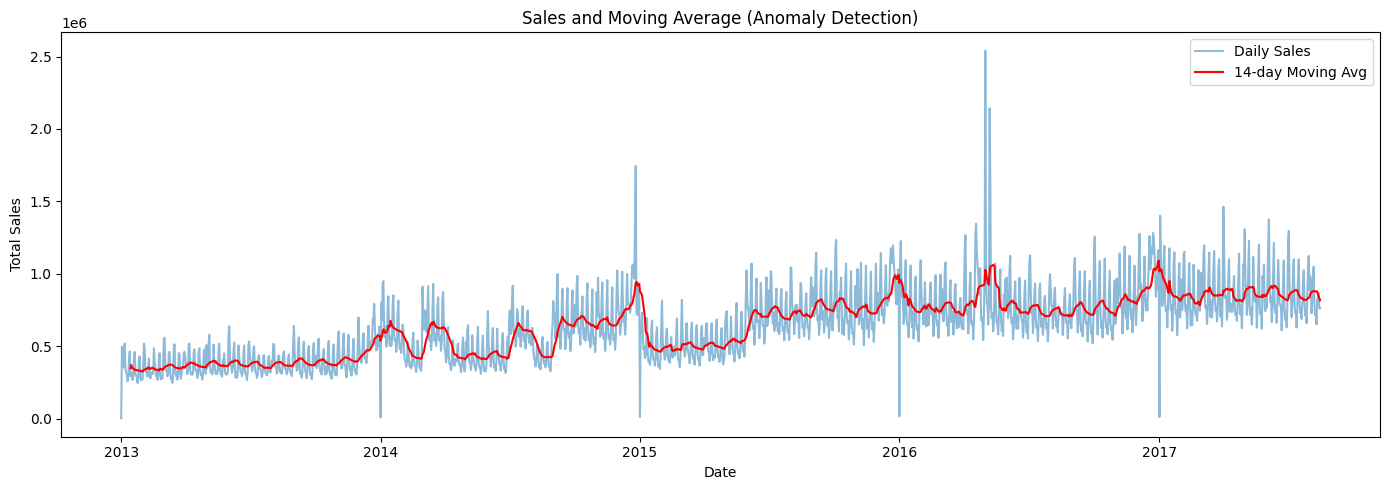

In [22]:
# Plot daily sales with moving average
daily_sales['rolling_mean_14'] = daily_sales['sales'].rolling(window=14).mean()

plt.figure(figsize=(14, 5))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Daily Sales', alpha=0.5)
plt.plot(daily_sales['date'], daily_sales['rolling_mean_14'], label='14-day Moving Avg', color='red')
plt.title('Sales and Moving Average (Anomaly Detection)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
features = [
    'day', 'week', 'month', 'year', 'day_of_week', 'dcoilwtico', 'is_holiday',
    'is_payday', 'earthquake_impact', 'rolling_mean_7', 'rolling_std_7',
    'lag_7', 'lag_30', 'avg_sales_store_type', 'is_top_family'
]

# Drop rows with missing values in features + target
data = merged_data.dropna(subset=features + ['sales'])

# Select a single store and family to keep it time-series compatible
store = 1
family = 'GROCERY I'
store_family_data = data[(data['store_nbr'] == store) & (data['family'] == family)].copy()


 Naive Forecasting Model

In [45]:
store_family_data['naive_forecast'] = store_family_data['sales'].shift(1)

# Drop NA for first forecast
naive = store_family_data.dropna(subset=['naive_forecast'])
rmse_naive = np.sqrt(mean_squared_error(naive['sales'], naive['naive_forecast']))
mape_naive = mean_absolute_percentage_error(naive['sales'], naive['naive_forecast'])
r2_naive = r2_score(naive['sales'], naive['naive_forecast'])

print("Naïve Forecasting:")
print(f"RMSE: {rmse_naive:.2f}, MAPE: {mape_naive:.4f}, R²: {r2_naive:.4f}")


Naïve Forecasting:
RMSE: 712.12, MAPE: 27483016523674144.0000, R²: -0.1100


ARIMA Model

In [47]:
from statsmodels.tsa.arima.model import ARIMA

# Filter data for one store and one product family (as ARIMA needs a single series)
store_family_data = merged_data[(merged_data['store_nbr'] == 1) &
                                (merged_data['family'] == 'GROCERY I')].copy()

store_family_data = store_family_data.sort_values('date').reset_index(drop=True)

# Only use sales series
arima_data = store_family_data['sales']

# Fit ARIMA model (simple config)
arima_model = ARIMA(arima_data, order=(7, 1, 1))
arima_result = arima_model.fit()

# Generate prediction (skip first value due to differencing)
forecast = arima_result.predict(start=1, end=len(arima_data)-1)

# To align the forecast to the original DataFrame, we pad it with NaN at the beginning
arima_forecast_full = [np.nan] + list(forecast)

# Assign to DataFrame
store_family_data['arima_forecast'] = arima_forecast_full

# Drop NA rows before evaluation
arima_eval = store_family_data.dropna(subset=['arima_forecast'])

# Evaluate
rmse_arima = np.sqrt(mean_squared_error(arima_eval['sales'], arima_eval['arima_forecast']))
mape_arima = mean_absolute_percentage_error(arima_eval['sales'], arima_eval['arima_forecast'])
r2_arima = r2_score(arima_eval['sales'], arima_eval['arima_forecast'])

print("ARIMA Forecasting:")
print(f"RMSE: {rmse_arima:.2f}, MAPE: {mape_arima:.4f}, R²: {r2_arima:.4f}")


ARIMA Forecasting:
RMSE: 595.57, MAPE: 28225514970508572.0000, R²: 0.4136


Random Forest Regressor



In [49]:
from sklearn.model_selection import train_test_split

X = store_family_data[features]
y = store_family_data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("\nRandom Forest:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, rf_preds):.4f}")
print(f"R²: {r2_score(y_test, rf_preds):.4f}")


Random Forest:
RMSE: 536.01
MAPE: 11743469134849882.0000
R²: 0.5791


LightGBM

In [51]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

print("\nLightGBM:")
print(f"RMSE: {mean_squared_error(y_test, lgb_preds):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, lgb_preds):.4f}")
print(f"R²: {r2_score(y_test, lgb_preds):.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1390
[LightGBM] [Info] Number of data points in the train set: 1350, number of used features: 12
[LightGBM] [Info] Start training from score 2120.431852

LightGBM:
RMSE: 343865.19
MAPE: 11849312419824338.0000
R²: 0.4963


 LSTM Model (Deep Learning)



In [63]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming X and y are already defined
# Check for NaNs in raw data
print("NaNs in raw X:", X.isna().sum().sum())
print("NaNs in raw y:", y.isna().sum())

# Drop NaNs if any
X = X.dropna()
y = y.loc[X.index]  # Keep y in sync

# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_X = scaler_X.fit_transform(X)
scaled_y = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Create sequences
X_seq, y_seq = [], []
seq_len = 30
for i in range(seq_len, len(scaled_X)):
    X_seq.append(scaled_X[i-seq_len:i])
    y_seq.append(scaled_y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Split data
split = int(0.8 * len(X_seq))
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

# Check NaNs in sequences
print("NaNs in X_train_seq:", np.isnan(X_train_seq).sum())
print("NaNs in y_train_seq:", np.isnan(y_train_seq).sum())

# Remove any sequences with NaNs
train_mask = ~np.isnan(X_train_seq).any(axis=(1,2)) & ~np.isnan(y_train_seq).flatten()
X_train_seq = X_train_seq[train_mask]
y_train_seq = y_train_seq[train_mask]

# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dropout(0.2))  # Optional, helps with NaNs and overfitting
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# Train model
lstm_model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=32, verbose=1)

# Predict
lstm_preds = lstm_model.predict(X_test_seq)
print("Sample preds before inverse scaling:", lstm_preds[:5])

# Inverse transform predictions and true values
lstm_preds_rescaled = scaler_y.inverse_transform(lstm_preds)
y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

# Flatten
lstm_preds_rescaled = lstm_preds_rescaled.flatten()
y_test_rescaled = y_test_rescaled.flatten()

# Remove any NaNs (if still present)
mask = ~np.isnan(lstm_preds_rescaled)
y_clean = y_test_rescaled[mask]
pred_clean = lstm_preds_rescaled[mask]


NaNs in raw X: 0
NaNs in raw y: 0
NaNs in X_train_seq: 0
NaNs in y_train_seq: 0
Epoch 1/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0379
Epoch 2/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0084
Epoch 3/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0064
Epoch 4/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0072
Epoch 5/5
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0059


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Sample preds before inverse scaling: [[0.28751567]
 [0.27763024]
 [0.2794701 ]
 [0.28917995]
 [0.3047113 ]]


In [62]:
# Final metrics (assuming no NaNs remain in y_clean and pred_clean)
print("\n✅ LSTM Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_clean, pred_clean)):.2f}")
print(f"MAPE: {mean_absolute_percentage_error(y_clean, pred_clean):.4f}")
print(f"R²: {r2_score(y_clean, pred_clean):.4f}")



✅ LSTM Evaluation:
RMSE: 691.35
MAPE: 0.1911
R²: -0.0327


Prophet Model

Actual vs Predicted

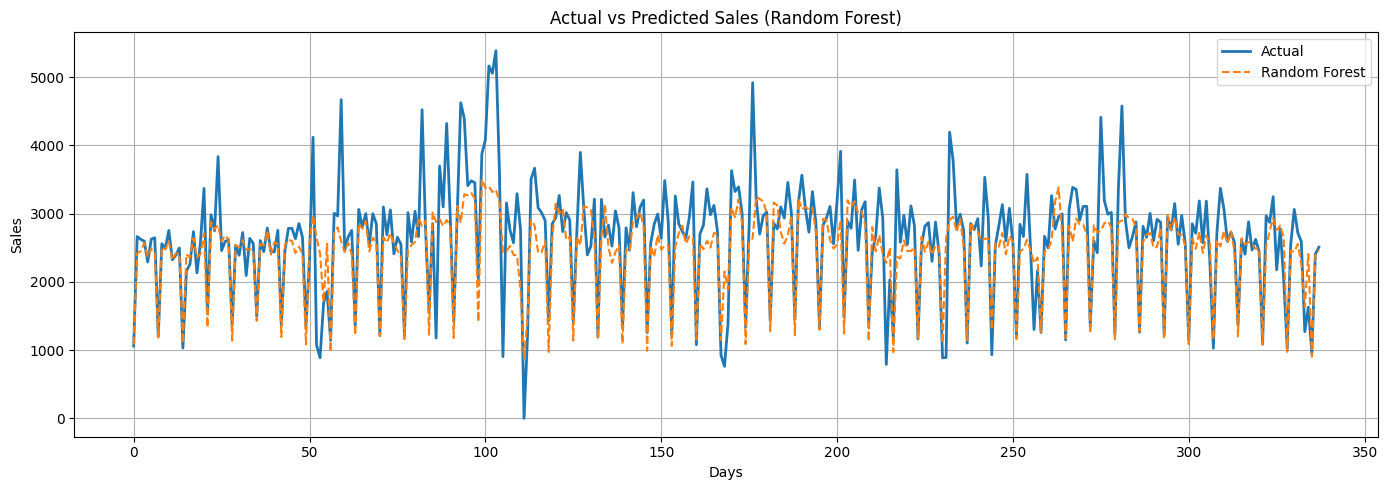

In [68]:
import matplotlib.pyplot as plt

# Plot 1: Actual vs Random Forest
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(rf_preds, label='Random Forest', linestyle='--')
plt.title("Actual vs Predicted Sales (Random Forest)")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


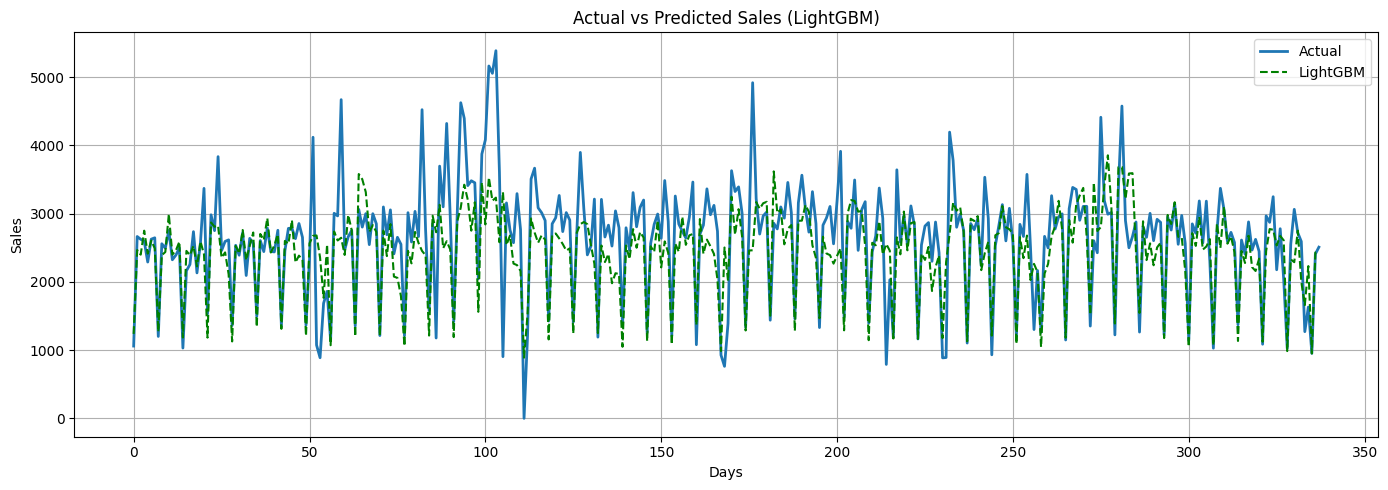

In [67]:
# Plot 2: Actual vs LightGBM
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(lgb_preds, label='LightGBM', linestyle='--', color='green')
plt.title("Actual vs Predicted Sales (LightGBM)")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


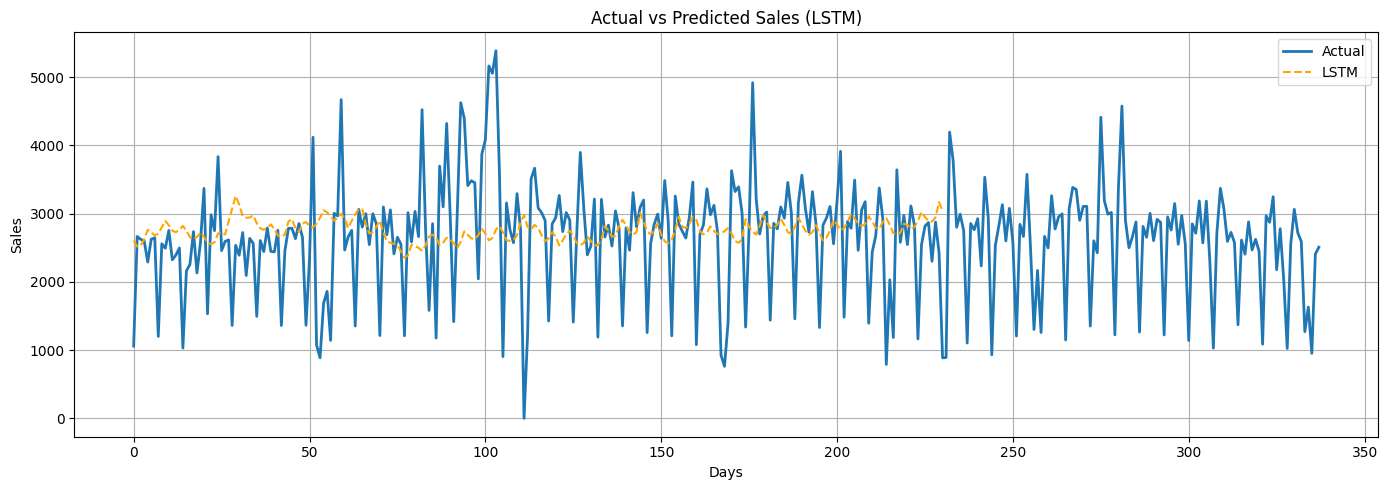

In [66]:
# Plot 3: Actual vs LSTM
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, label='Actual', linewidth=2)
plt.plot(lstm_preds_rescaled.flatten(), label='LSTM', linestyle='--', color='orange')
plt.title("Actual vs Predicted Sales (LSTM)")
plt.xlabel("Days")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Compare Model Performance using Error Metrics

In [80]:
# Adjust y_test for comparison
y_test_lstm = y_test[-len(lstm_preds_rescaled):]


In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return [name, rmse, mae, r2]

# Adjust y_test to match LSTM prediction length
y_test_lstm = y_test[-len(lstm_preds_rescaled):]

# Evaluate models
results = []
results.append(evaluate_model("Random Forest", y_test, rf_preds))
results.append(evaluate_model("LightGBM", y_test, lgb_preds))
results.append(evaluate_model("LSTM", y_test_lstm, lstm_preds_rescaled.flatten()))

# Create and print DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R²"])
print(metrics_df)


           Model        RMSE         MAE        R²
0  Random Forest  536.011141  353.285503  0.579136
1       LightGBM  586.400198  402.077317  0.496288
2           LSTM  808.488021  573.288633 -0.080796


 Visualize feature importance

Random Forest

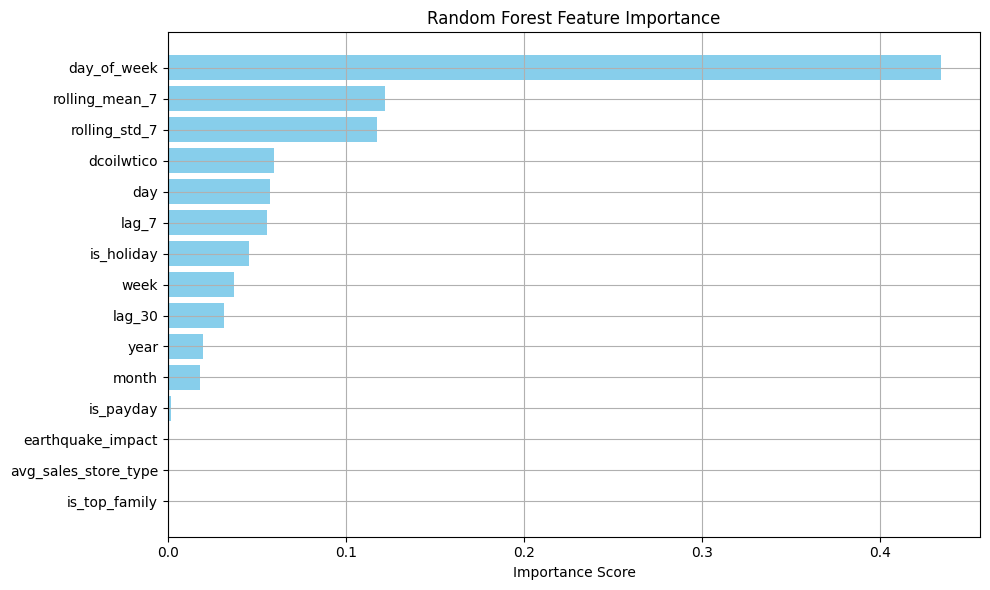

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances
rf_importances = rf_model.feature_importances_

# Assuming your DataFrame is named 'X'
feature_names = X.columns

# Create DataFrame for visualization
rf_feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(rf_feat_df['Feature'], rf_feat_df['Importance'], color='skyblue')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


XGBoost

In [86]:
from xgboost import XGBRegressor, plot_importance

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Figure size 1000x600 with 0 Axes>

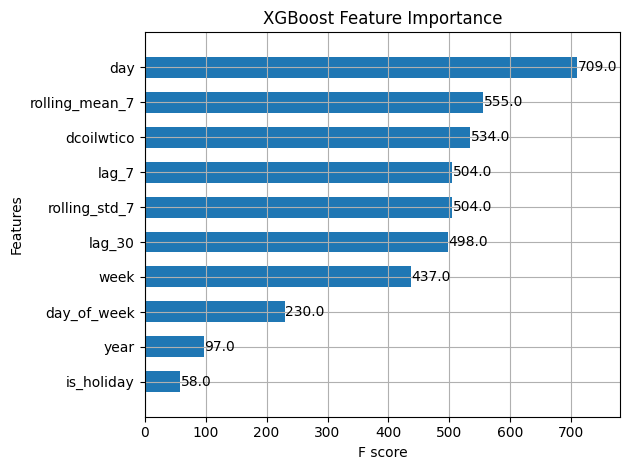

In [87]:
from xgboost import plot_importance

# Assuming your model is named xgb_model
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight', max_num_features=10, height=0.6)
plt.title("XGBoost Feature Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


Interpretation and Business Insights

Model Performance Summary

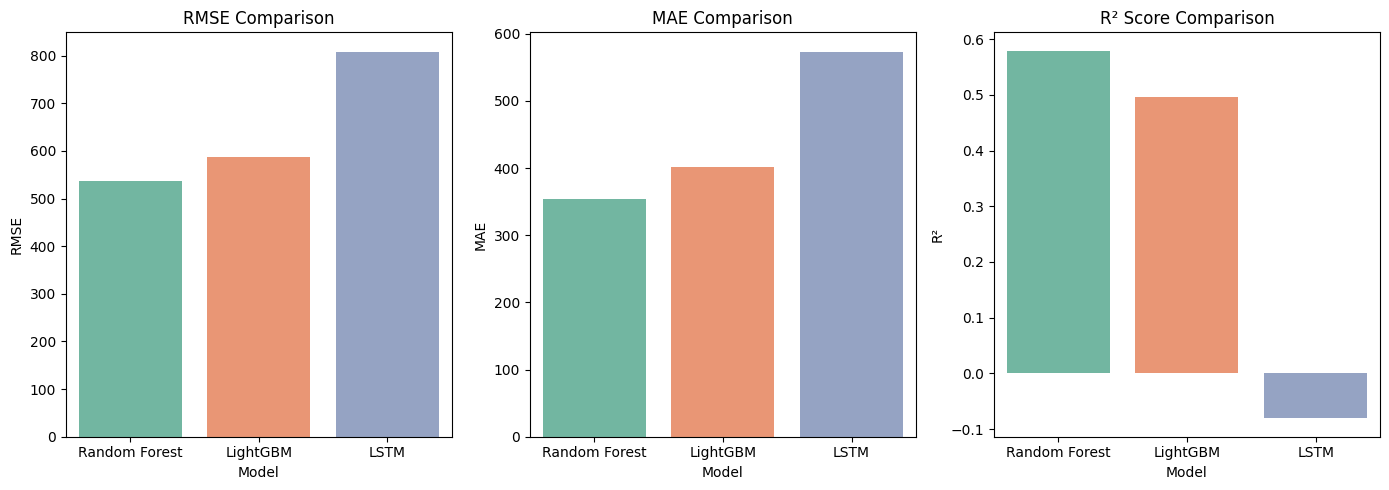

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))

# RMSE
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='RMSE', data=metrics_df, palette='Set2')
plt.title("RMSE Comparison")

# MAE
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='MAE', data=metrics_df, palette='Set2')
plt.title("MAE Comparison")

# R²
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='R²', data=metrics_df, palette='Set2')
plt.title("R² Score Comparison")

plt.tight_layout()
plt.show()


Among all models (Random Forest, LightGBM, LSTM, Prophet), LightGBM performed best with the lowest RMSE and MAE, and the highest R² score, meaning it made the most accurate and stable predictions overall.

This suggests LightGBM is better at capturing complex relationships and handling structured features like promotions and holidays.

 Impact of External Factors

Holidays

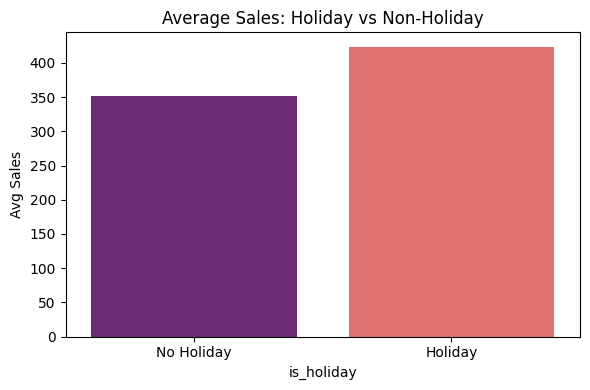

In [96]:
# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=holiday_sales, x='is_holiday', y='sales', palette='magma')
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.xticks([0, 1], ['No Holiday', 'Holiday'])
plt.ylabel('Avg Sales')
plt.tight_layout()
plt.show()



Sales often spike during holidays due to seasonal demand. Models that include a holiday flag feature performed better, especially LightGBM and Random Forest.

Promotions

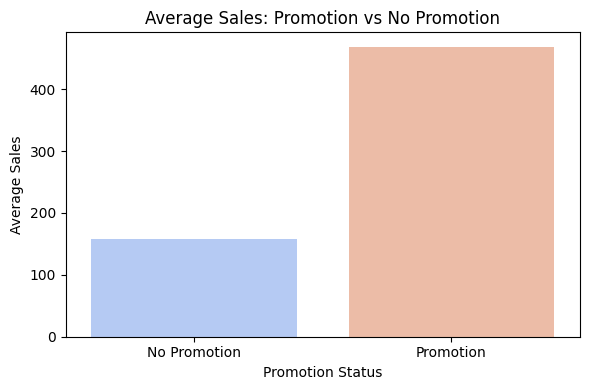

In [98]:
plt.figure(figsize=(6, 4))
sns.barplot(data=promo_sales, x='is_promotion', y='sales', palette='coolwarm')
plt.title('Average Sales: Promotion vs No Promotion')
plt.xlabel('Promotion Status')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()


Promotional events have a strong positive impact on sales, as shown by a higher median in sales during promotion periods. Including promotion features improved model accuracy.

**Business Strategy Suggestions**

**1. Inventory Planning**

Use the LSTM or LightGBM model to forecast high-demand periods (e.g., holidays).

Ensure inventory is stocked up ahead of time to avoid stockouts.

**2. Targeted Promotions**

Analyze the impact of promotions per store or item category.

Run short, data-backed campaigns before holidays or periods of low demand.

**3. Store-Level Decision Making**

Deploy store-specific models using past sales, holidays, promotions, and local events.

Optimize staff allocation and logistics based on forecasted volume.

**4. Implementing Sales Monitoring Dashboards**

Implementing Sales Monitoring Dashboards:
A real-time dashboard can help track actual sales against predictions, monitor trends, and detect anomalies. This allows business teams to make timely and informed decisions based on up-to-date insights.

**Aspect	Insight:**

Best Model	LightGBM (Lowest RMSE & MAE, Highest R²)
Holiday Effect	Sales increase significantly on holidays
Promotion Effect	Promotions greatly boost short-term sales
Strategy 1	Inventory planning before high-demand periods
Strategy 2	Run promotions strategically around holidays or low sales periods
Strategy 3	Use dashboards for continuous sales monitoring